In [1]:
from pathlib import Path
import re
import string
import pandas as pd
from sklearn.model_selection import train_test_split


def load_data(path: Path) -> pd.DataFrame:
    data = pd.read_csv(path)
    data = pd.DataFrame(
        {
            "job_description": data[
                ["company_profile", "description", "requirements", "benefits"]
            ]
            .fillna("")
            .agg(" ".join, axis=1),
            "fraudulent": data["fraudulent"],
        }
    )
    data = data.drop_duplicates(subset=["job_description"], keep="first")
    return data

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def split_data(data: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(
        data["job_description"],
        data["fraudulent"],
        test_size=0.2,
        random_state=42,
        stratify=data["fraudulent"],
    )

    # Convert to DataFrame for easy manipulation
    train_df = pd.DataFrame({'job_description': X_train, 'fraudulent': y_train})

    # Separate fraudulent (y=1) and non-fraudulent (y=0) samples
    fraudulent_df = train_df[train_df['fraudulent'] == 1]
    non_fraudulent_df = train_df[train_df['fraudulent'] == 0]
    print(fraudulent_df.shape, non_fraudulent_df.shape)

    # Oversample each fraudulent job description exactly 21 times
    fraudulent_df_oversampled = pd.concat([fraudulent_df] * 21, ignore_index=True)

    # Combine the oversampled fraudulent data with the original non-fraudulent data
    train_df_oversampled = pd.concat([non_fraudulent_df, fraudulent_df_oversampled], ignore_index=True)

    # Shuffle the data
    train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract the oversampled X_train and y_train
    X_train: pd.Series[str] = train_df_oversampled['job_description']
    y_train: pd.Series[int] = train_df_oversampled['fraudulent']

    # apply clean_text function to the training and test data

    X_train = X_train.apply(clean_text)
    X_test = X_test.apply(clean_text)

    return X_train, X_test, y_train, y_test


In [2]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
print("Path to dataset files:", path)

data = load_data(Path(path + "/fake_job_postings.csv"))

X_train, X_test, y_train, y_test = split_data(data)

print(X_train.head())
print(y_train.head())

100%|██████████| 16.1M/16.1M [00:00<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1
(547, 2) (11832, 2)
0     in trading is a vertically integrated solid w...
1    we believe cities are complicated and your mob...
2    smarter good is an innovative global services ...
3    join the your phone connect team and earn mone...
4    at total eclipse we create fun original and ad...
Name: job_description, dtype: object
0    0
1    0
2    0
3    1
4    0
Name: fraudulent, dtype: int64


In [3]:
from transformers import AutoTokenizer

# Load BERT-large tokenizer
model_name = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the dataset
def preprocess_data(texts, labels):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Tokenize training & test sets
train_encodings = preprocess_data(X_train.tolist(), y_train.tolist())
test_encodings = preprocess_data(X_test.tolist(), y_test.tolist())


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
import torch

class FakeJobDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch datasets
train_dataset = FakeJobDataset(train_encodings, y_train.tolist())
test_dataset = FakeJobDataset(test_encodings, y_test.tolist())


In [5]:
from transformers import AutoModelForSequenceClassification

# Load BERT-large with classification head
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",      # Directory for model checkpoints
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save model at each epoch
    per_device_train_batch_size=4,  # Reduce batch size due to memory limits
    per_device_eval_batch_size=4,
    num_train_epochs=1,          # Adjust based on dataset size
    learning_rate=2e-5,          # Recommended LR for fine-tuning BERT
    weight_decay=0.01,           # Regularization
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,          # Keep only the 2 latest models
    fp16=True,                   # Enable mixed precision (A100 supports it)
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pclouduwu (pclouduwu-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.000100,0.131124


TrainOutput(global_step=5830, training_loss=0.11625104177297703, metrics={'train_runtime': 654.737, 'train_samples_per_second': 35.616, 'train_steps_per_second': 8.904, 'total_flos': 2.173170746144563e+16, 'train_loss': 0.11625104177297703, 'epoch': 1.0})

In [9]:
# Save model locally
model.save_pretrained("bert-large-fake-job-classifier")
tokenizer.save_pretrained("bert-large-fake-job-classifier")

# Upload to Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()  # Logs into Hugging Face

model.push_to_hub("pcloud/job_catcher-bert-large-uncased")
tokenizer.push_to_hub("pcloud/job_catcher-bert-large-uncased")


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pcloud/job_catcher-bert-large-uncased/commit/c021217769194fbe9f6bda9f3f9ddc93f0cdd088', commit_message='Upload tokenizer', commit_description='', oid='c021217769194fbe9f6bda9f3f9ddc93f0cdd088', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pcloud/job_catcher-bert-large-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='pcloud/job_catcher-bert-large-uncased'), pr_revision=None, pr_num=None)

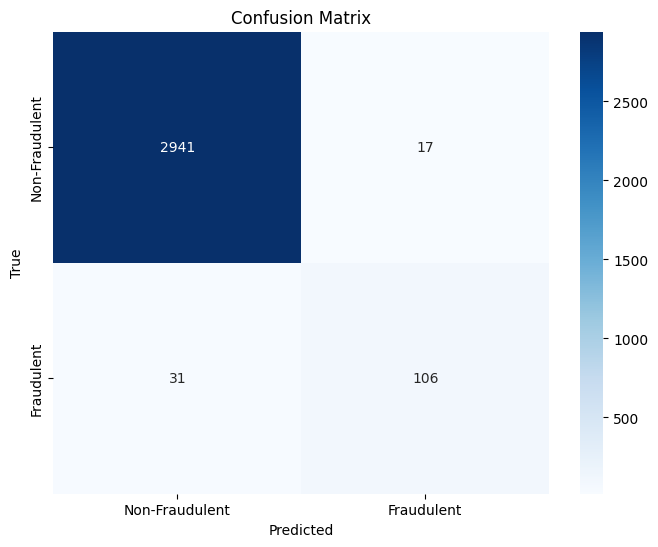

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Get predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Evaluate with per-class precision, recall, F1-score
print(classification_report(y_test, predicted_labels))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraudulent", "Fraudulent"],
            yticklabels=["Non-Fraudulent", "Fraudulent"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
classification_report(y_test, predicted_labels)

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      2958\n           1       0.86      0.77      0.82       137\n\n    accuracy                           0.98      3095\n   macro avg       0.93      0.88      0.90      3095\nweighted avg       0.98      0.98      0.98      3095\n'

In [ ]:
#               precision    recall  f1-score   support

#            0       0.99      0.99      0.99      2958
#            1       0.86      0.77      0.82       137

#     accuracy                           0.98      3095
#    macro avg       0.93      0.88      0.90      3095
# weighted avg       0.98      0.98      0.98      3095
